In [1]:
import os
import sys
import inspect
_parent_dir = os.path.dirname(os.path.dirname(os.path.dirname(
    os.path.abspath(inspect.getfile(inspect.currentframe())))))
sys.path.insert(0, _parent_dir)

In [2]:
import torch
import pickle
import numpy as np
from scipy.misc import imsave, imshow
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

In [15]:
from torch.autograd import Variable
import math
import torch
import seaborn as sns
from matplotlib import offsetbox
from dqn.utils import read_pickle, plot_state, read_json, move_to_gpu, create_batch
from dqn.models import VanillaDQN
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
exp_path = "../runs/standard_dqn_pong_1"

In [74]:
snapshot = torch.load(exp_path + "/snapshots/snapshot_37.pth.tar")

In [59]:
params = read_json(exp_path, "params.txt")

In [75]:
model = VanillaDQN(env_obs_space=tuple(params["env"]["obs_space"]),
                   env_num_actions=params["env"]["num_actions"],
                   nn_hidden_size=params["training"]["hidden_size"])
model.init_weight(snapshot)
model = move_to_gpu(x=model, gpu=params["gpu"],
                    gpu_id=params["gpu_id"])

In [12]:
episodes = read_pickle(filename=os.path.join(exp_path, "episodes", "episode_play_348.pkl"))

In [44]:
import torch.nn as nn
loss_func = nn.MSELoss(reduce=False)

In [76]:
losses = []
embeddings = []
BATCH_SIZE = 128
for i in range(episodes.states.shape[0] // BATCH_SIZE):
    states, next_states, actions, rewards, dones = [], [], [], [], []
    for j in range(i * BATCH_SIZE, (i+1) * BATCH_SIZE):
        _s, _ns, _a, _r = episodes.sample_transition(
            idx=j, frame_stack=params["env_frame_stack"], 
            n_step=params["dqn_n_steps"], gamma=params["gamma"])
        states.append(np.array(_s, copy=False))
        actions.append(_a)
        rewards.append(_r)
        dones.append(int(_ns is None))
        if _ns is None:
            next_states.append(np.array(_s, copy=False))
        else:
            next_states.append(np.array(_ns, copy=False))
    states = np.array(states, copy=False)
    next_states = np.array(next_states, copy=False)
    actions = np.array(actions)
    rewards = np.array(rewards, dtype=np.float32)
    dones = np.array(dones, dtype=np.float32)
    
    states, next_states, actions, rewards, dones = create_batch(
        samples=(states, next_states, actions, rewards, dones), 
        gpu=params["gpu"],
        gpu_id=params["gpu_id"], gpu_async=params["gpu_async"],
        requires_grad=False)

    qs = model(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
    next_qs = model(next_states).max(dim=1)[0]
    next_qs *= (1 - dones)
    next_qs.volatile = False
    targets = rewards + next_qs * params["gamma"]
    _losses = (targets - qs).data.cpu().numpy()
#     _losses = loss_func(qs, targets).data.cpu().numpy()
    _batch_size = qs.size(0)
    _embeddings = model.conv(states).view(_batch_size, -1).data.cpu().numpy()
    losses.append(_losses)
    embeddings.append(_embeddings)

In [77]:
losses = np.concatenate(losses)

In [78]:
embeddings = np.concatenate(embeddings)

In [79]:
tsne_embeddings = TSNE(n_components=2).fit_transform(embeddings)

(array([1.000e+00, 0.000e+00, 1.000e+00, 5.000e+00, 1.500e+01, 1.690e+02,
        1.479e+03, 4.650e+02, 3.700e+01, 4.000e+00]),
 array([-0.82158911, -0.69815966, -0.57473021, -0.45130075, -0.3278713 ,
        -0.20444185, -0.08101239,  0.04241706,  0.16584651,  0.28927597,
         0.41270542]),
 <a list of 10 Patch objects>)

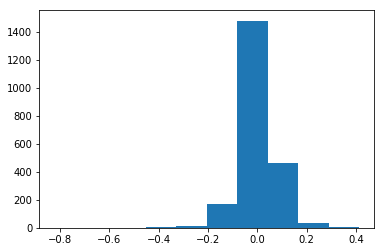

In [80]:
plt.hist(losses)

In [56]:
def plot_tsn_embedding(tsne, categories):
    vis_x = tsne[:, 0]
    vis_y = tsne[:, 1]
    cmap = sns.cubehelix_palette(50, start=.5, rot=-.75, as_cmap=True)

    f, ax = plt.subplots(figsize=(20, 10))
    points = ax.scatter(
        tsne[:, 0], 
        tsne[:, 1], 
        c=categories, 
        s=10, 
        cmap=cmap)
    f.colorbar(points)

In [54]:
def plot_embedding(X, categories, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)     
    fig, ax = plt.subplots(figsize=(20, 10))
    cmap = sns.cubehelix_palette(16, start=.5, rot=-.75, as_cmap=True)
    points = ax.scatter(
        X[:, 0], 
        X[:, 1], 
        c=categories, 
        s=10, 
        cmap=cmap)
    if hasattr(offsetbox, 'AnnotationBbox'):
        ## only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        idx = np.argsort(categories)[::-1]
#         idx = np.arange(X.shape[0])
        np.random.shuffle(idx)
        for _idx in range(X.shape[0]):
            i = idx[_idx]
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 0.01:
                ## don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(
                    np.rot90(np.flip(episodes.states[i], 1)), 
                    zoom=0.5,
                    cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    fig.colorbar(points)
    if title is not None:
        plt.title(title)

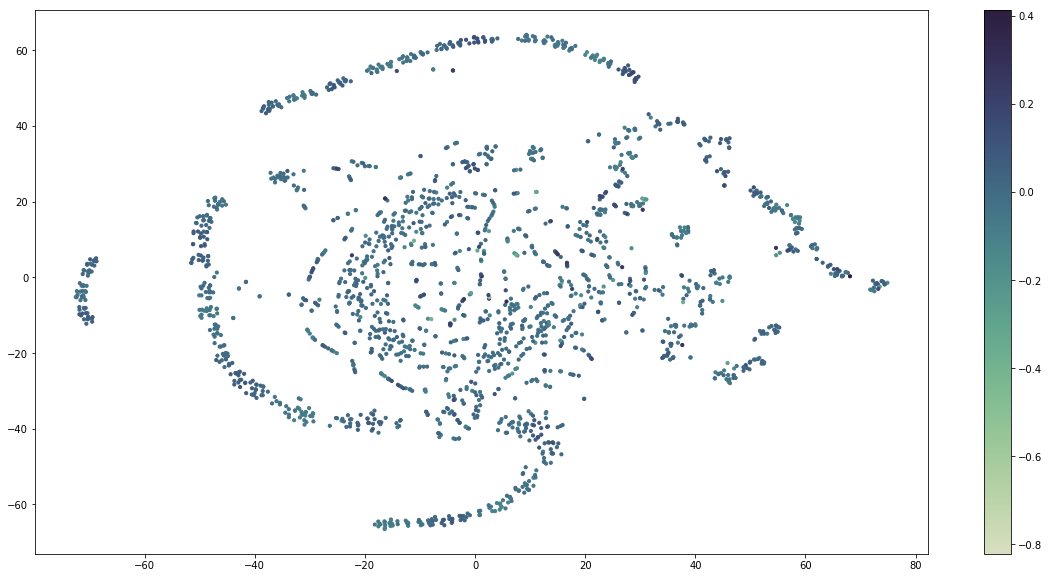

In [81]:
plot_tsn_embedding(tsne_embeddings, losses)

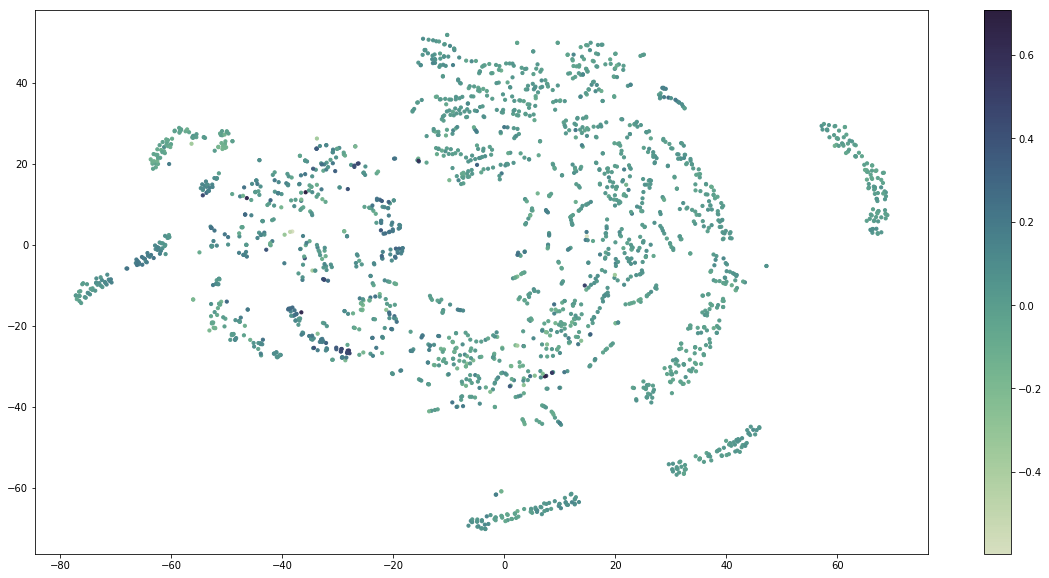

In [72]:
plot_tsn_embedding(tsne_embeddings, losses)

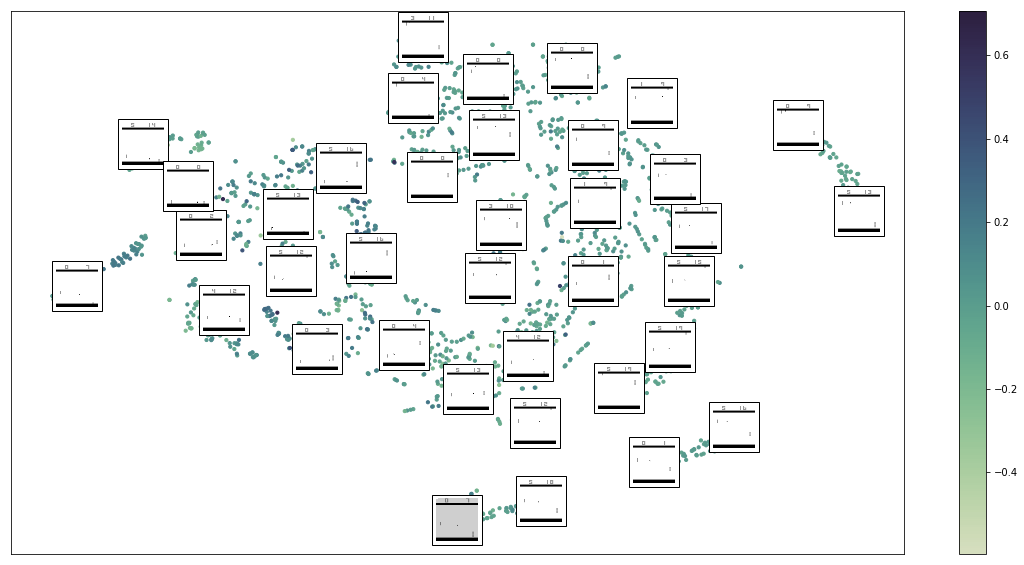

In [73]:
plot_embedding(tsne_embeddings, losses)